# Sales Forecasting System - Time Series Analysis

## 1. Import Libraries

In [ ]:
# ===== IMPORT REQUIRED LIBRARIES =====
# Mengimpor semua library yang dibutuhkan untuk analisis dan forecasting

import pandas as pd  # Data manipulation dan analysis
import numpy as np  # Numerical operations
from datetime import datetime, timedelta  # Operasi datetime
import matplotlib.pyplot as plt  # Plotting/visualisasi
import seaborn as sns  # Advanced plotting
from statsmodels.tsa.arima.model import ARIMA  # Model ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # Exponential Smoothing
from statsmodels.tsa.seasonal import seasonal_decompose  # Dekomposisi time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF dan PACF plots
from statsmodels.tsa.stattools import adfuller  # ADF test untuk stationarity
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Evaluasi model
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Konfigurasi pandas dan matplotlib untuk tampilan yang lebih baik
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Load and Explore Data

In [ ]:
# ===== LOAD DATA =====
# Membaca file CSV yang berisi data transaksi penjualan

df = pd.read_csv('Sales Transaction v.4a(modified).csv')

# Menampilkan informasi dasar tentang dataset
print("Dataset Shape:", df.shape)  # Jumlah baris dan kolom
print("\n" + "="*50)
print("First few rows:")
df.head()  # Menampilkan 5 baris pertama

Dataset Shape: (532253, 8)

First few rows:


,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581492,12/9/2019,23224,Cherub Heart Decoration Gold,6.19,1,15492.0,United Kingdom
1,581492,12/9/2019,23229,Vintage Donkey Tail Game,6.19,2,15492.0,United Kingdom
2,581492,12/9/2019,23234,Biscuit Tin Vintage Christmas,6.19,4,15492.0,United Kingdom
3,581492,12/9/2019,23241,Treasure Tin Gymkhana Design,6.19,3,15492.0,United Kingdom
4,581492,12/9/2019,23243,Set Of Tea Coffee Sugar Tins Pantry,6.19,1,15492.0,United Kingdom


### 2.1 Remove cancelled transactions and validate basic integrity

In [ ]:
# ===== REMOVE CANCELLED TRANSACTIONS =====
# Mendeteksi dan menghapus transaksi yang dibatalkan (dimulai dengan 'C')

print("Checking for cancelled transactions...")
print("="*50)

# Membuat kolom flag untuk transaksi dibatalkan (dimulai dengan 'C')
df['IsCancelled'] = df['TransactionNo'].astype(str).str.startswith('C')

# Hitung jumlah transaksi dibatalkan
cancelled_count = df['IsCancelled'].sum()
total_transactions = len(df)

print(f"Total Transactions: {total_transactions:,}")
print(f"Cancelled Transactions: {cancelled_count:,} ({cancelled_count/total_transactions*100:.2f}%)")
print(f"Valid Transactions: {total_transactions - cancelled_count:,} ({(total_transactions - cancelled_count)/total_transactions*100:.2f}%)")

if cancelled_count > 0:
    print(f"\nSample cancelled transactions:")
    print(df[df['IsCancelled']].head())
    
    # Hapus transaksi dibatalkan dari dataset
    print(f"\nRemoving {cancelled_count:,} cancelled transactions...")
    df = df[~df['IsCancelled']].copy()
    print(f"✓ Clean dataset: {len(df):,} valid transactions")
else:
    print("\n✓ No cancelled transactions found - dataset is clean")

print("="*50)

Checking for cancelled transactions...
Total Transactions: 532,253
Cancelled Transactions: 8,578 (1.61%)
Valid Transactions: 523,675 (98.39%)

Sample cancelled transactions:
    TransactionNo       Date ProductNo                       ProductName  \
792       C581484  12/9/2019     23843         Paper Craft Little Birdie   
793       C581490  12/9/2019     22178   Victorian Glass Hanging T-Light   
794       C581490  12/9/2019     23144   Zinc T-Light Holder Stars Small   
795       C581568  12/9/2019     21258        Victorian Sewing Box Large   
796       C581569  12/9/2019     84978  Hanging Heart Jar T-Light Holder   

     Price  Quantity  CustomerNo         Country  IsCancelled  
792   6.19    -80995     16446.0  United Kingdom         True  
793   6.19       -12     14397.0  United Kingdom         True  
794   6.04       -11     14397.0  United Kingdom         True  
795   6.19        -5     15311.0  United Kingdom         True  
796   6.19        -1     17315.0  United Kingdom 

### 2.3 Data quality checks

In [ ]:
# ===== DATA QUALITY CHECK =====
# Memastikan tidak ada nilai negatif atau missing values di kolom kunci

print("\nData Quality Check:")
print("="*50)

# Cek nilai negatif
negative_qty = (df['Quantity'] < 0).sum()
negative_price = (df['Price'] < 0).sum()
print(f"Negative Quantities: {negative_qty}")
print(f"Negative Prices: {negative_price}")

# Jika ada nilai negatif, hapus records tersebut
if negative_qty > 0 or negative_price > 0:
    print(f"\nRemoving {negative_qty + negative_price} records with negative values...")
    df = df[(df['Quantity'] > 0) & (df['Price'] > 0)].copy()
    print(f"✓ Cleaned dataset: {len(df):,} records")

# Cek missing values di kolom kunci
key_columns = ['Date', 'ProductNo', 'Price', 'Quantity']
missing_summary = df[key_columns].isnull().sum()

if missing_summary.sum() > 0:
    print(f"\nMissing values found:")
    print(missing_summary[missing_summary > 0])
    df = df.dropna(subset=key_columns)  # Hapus rows dengan missing values
    print(f"✓ Cleaned dataset: {len(df):,} records")
else:
    print(f"\n✓ No missing values in key columns")

print("="*50)
print(f"\nFinal Clean Dataset: {len(df):,} transactions")
print("="*50)


Data Quality Check:
Negative Quantities: 0
Negative Prices: 0

✓ No missing values in key columns

Final Clean Dataset: 523,675 transactions


In [ ]:
# ===== EXPLORATORY DATA ANALYSIS =====
# Menampilkan statistik deskriptif dan info dataset

print("Data Types:")
print(df.dtypes)  # Tipe data setiap kolom
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())  # Jumlah missing values per kolom
print("\n" + "="*50)
print("\nBasic Statistics:")
df.describe()  # Statistik deskriptif (mean, std, min, max, dll)

Data Types:
TransactionNo     object
Date              object
ProductNo         object
ProductName       object
Price            float64
Quantity           int64
CustomerNo       float64
Country           object
IsCancelled         bool
dtype: object


Missing Values:
TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       1
Country          0
IsCancelled      0
dtype: int64


Basic Statistics:


,Price,Quantity,CustomerNo
count,523675.000000,523675.000000,523674.000000
mean,12.635691,10.312291,15233.818253
std,7.954118,41.612689,1714.716425
min,5.130000,1.000000,12004.000000
25%,10.990000,1.000000,13816.000000
50%,11.940000,3.000000,15159.000000
75%,14.090000,11.000000,16729.000000
max,660.620000,12540.000000,18287.000000


## 3. Data Preprocessing for Time Series

In [ ]:
# ===== DATA PREPROCESSING FOR TIME SERIES =====
# Mengubah format data menjadi time series harian

# Convert Date ke datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Hitung Revenue = Price × Quantity
df['Revenue'] = df['Price'] * df['Quantity']

# Agregasi data berdasarkan harian (daily level)
# Hitung: jumlah transaksi, total quantity, total revenue per hari
daily_sales = df.groupby('Date').agg({
    'TransactionNo': 'count',  # Jumlah transaksi
    'Quantity': 'sum',          # Total quantity terjual
    'Revenue': 'sum'            # Total revenue
}).reset_index()

# Rename kolom untuk kejelasan
daily_sales.columns = ['Date', 'NumTransactions', 'TotalQuantity', 'TotalRevenue']

# Sort berdasarkan tanggal dan reset index
daily_sales = daily_sales.sort_values('Date').reset_index(drop=True)

print("Daily Sales Data Shape:", daily_sales.shape)
print("\nDate Range:", daily_sales['Date'].min(), "to", daily_sales['Date'].max())
print("\n" + "="*50)
daily_sales.head(10)  # Tampilkan 10 baris pertama

Daily Sales Data Shape: (305, 4)

Date Range: 2018-12-01 00:00:00 to 2019-12-09 00:00:00



,Date,NumTransactions,TotalQuantity,TotalRevenue
0,2018-12-01,3061,26889,326820.08
1,2018-12-02,2057,31297,367316.62
2,2018-12-03,2136,16164,206313.62
3,2018-12-05,2694,16357,197565.27
4,2018-12-06,3823,21867,273420.10
5,2018-12-07,2904,25307,337840.78
6,2018-12-08,2557,23064,269961.77
7,2018-12-09,2754,19879,253406.71
8,2018-12-10,2671,21055,270340.27
9,2018-12-12,1438,10601,125413.55


In [ ]:
# ===== SET TIME SERIES FORMAT =====
# Mengubah data menjadi time series dengan index tanggal

# Set Date sebagai index dan pastikan frequency harian
ts_data = daily_sales.set_index('Date')
ts_data = ts_data.asfreq('D', method='ffill')  # Forward fill untuk hari yang missing

print("Time Series Data Shape:", ts_data.shape)
print("\nTime Series Statistics:")
ts_data.describe()  # Statistik deskriptif data time series

Time Series Data Shape: (374, 3)

Time Series Statistics:


,NumTransactions,TotalQuantity,TotalRevenue
count,374.000000,374.000000,374.000000
mean,1661.721925,17017.368984,191772.131043
std,807.657944,8888.947170,96979.051427
min,32.000000,173.000000,1658.410000
25%,1105.750000,10651.500000,126182.715000
50%,1477.000000,15576.500000,179970.570000
75%,1980.250000,21416.500000,233955.657500
max,5276.000000,47314.000000,563732.790000


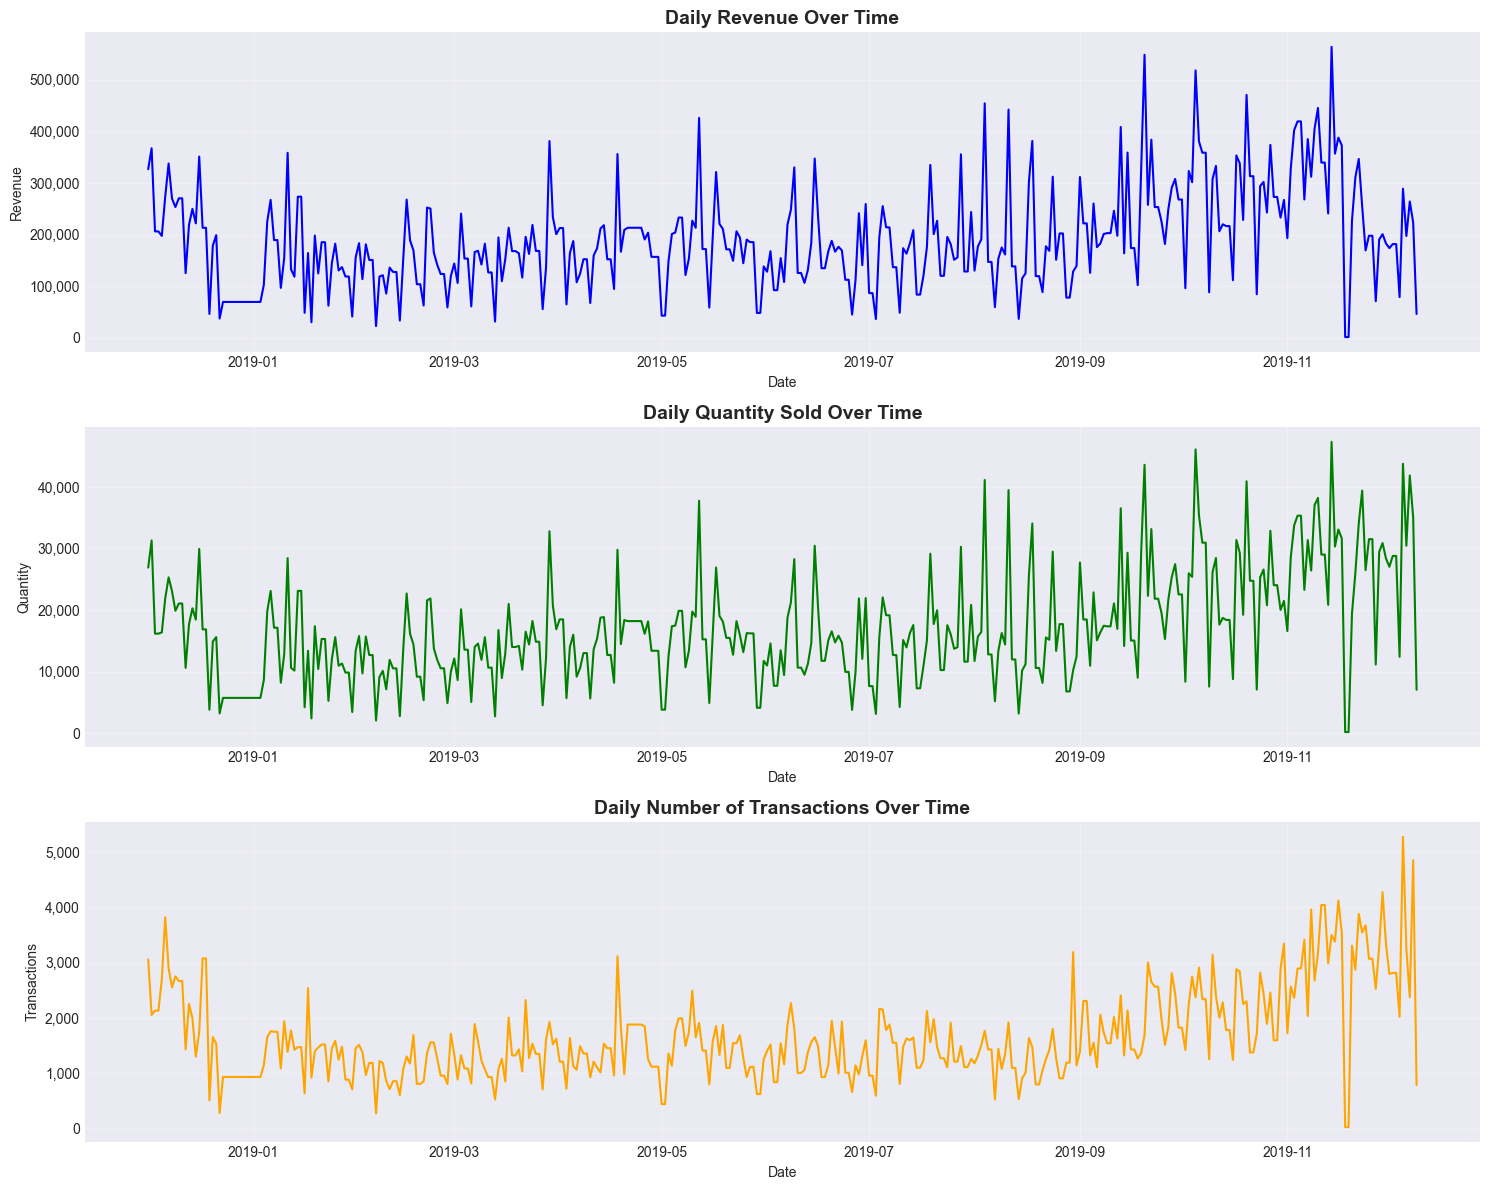

In [ ]:
# ===== VISUALISASI TIME SERIES =====
# Plot 3 metrik penjualan utama: Revenue, Quantity, dan Transactions

from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Daily Revenue over time
axes[0].plot(ts_data.index, ts_data['TotalRevenue'], color='blue', linewidth=1.5)
axes[0].set_title('Daily Revenue Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenue')
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(style='plain', axis='y', useOffset=False)
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.0f}'))

# Plot 2: Daily Quantity over time
axes[1].plot(ts_data.index, ts_data['TotalQuantity'], color='green', linewidth=1.5)
axes[1].set_title('Daily Quantity Sold Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Quantity')
axes[1].grid(True, alpha=0.3)
axes[1].ticklabel_format(style='plain', axis='y', useOffset=False)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.0f}'))

# Plot 3: Daily Transactions over time
axes[2].plot(ts_data.index, ts_data['NumTransactions'], color='orange', linewidth=1.5)
axes[2].set_title('Daily Number of Transactions Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Transactions')
axes[2].grid(True, alpha=0.3)
axes[2].ticklabel_format(style='plain', axis='y', useOffset=False)
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

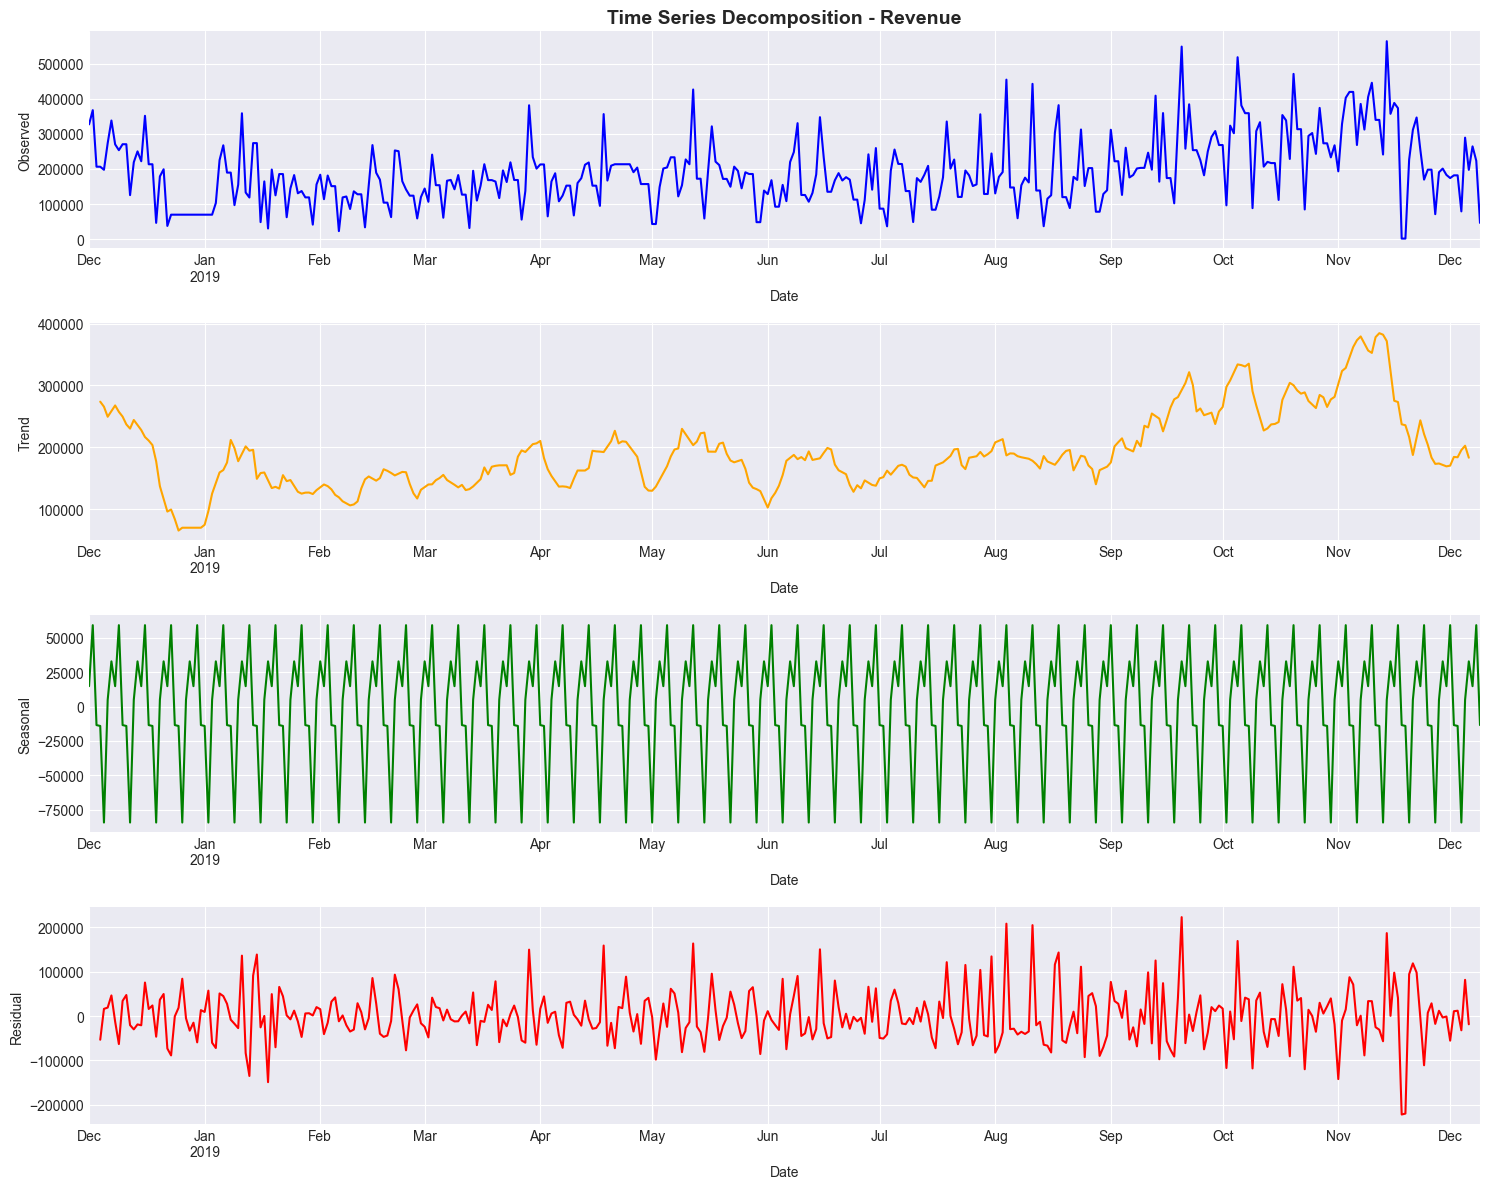

In [ ]:
# ===== TIME SERIES DECOMPOSITION =====
# Memisahkan trend, seasonal, dan residual komponen dari time series

# Dekomposisi dengan periode 7 hari (weekly seasonality)
decomposition = seasonal_decompose(ts_data['TotalRevenue'], model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Plot komponen observed (original data)
decomposition.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Observed')
axes[0].set_title('Time Series Decomposition - Revenue', fontsize=14, fontweight='bold')

# Plot trend component
decomposition.trend.plot(ax=axes[1], color='orange')
axes[1].set_ylabel('Trend')

# Plot seasonal component
decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')

# Plot residual component
decomposition.resid.plot(ax=axes[3], color='red')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [ ]:
# ===== AUGMENTED DICKEY-FULLER (ADF) TEST =====
# Mengecek apakah time series stasioner (penting untuk ARIMA)
# H0: data non-stasioner, H1: data stasioner

def adf_test(series, title=''):
    """
    Fungsi untuk melakukan Augmented Dickey-Fuller test
    H0 (Null Hypothesis): series adalah non-stasioner
    H1 (Alternative): series adalah stasioner
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f'ADF Test Results for {title}')
    print('='*50)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("\n✓ Series is STATIONARY (p-value <= 0.05)")
    else:
        print("\n✗ Series is NON-STATIONARY (p-value > 0.05)")
        print("  → Differencing may be needed")
    print('='*50)

# Lakukan ADF test pada revenue series
adf_test(ts_data['TotalRevenue'], 'Original Revenue Series')

ADF Test Results for Original Revenue Series
ADF Statistic: -3.194466
p-value: 0.020307
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571

✓ Series is STATIONARY (p-value <= 0.05)


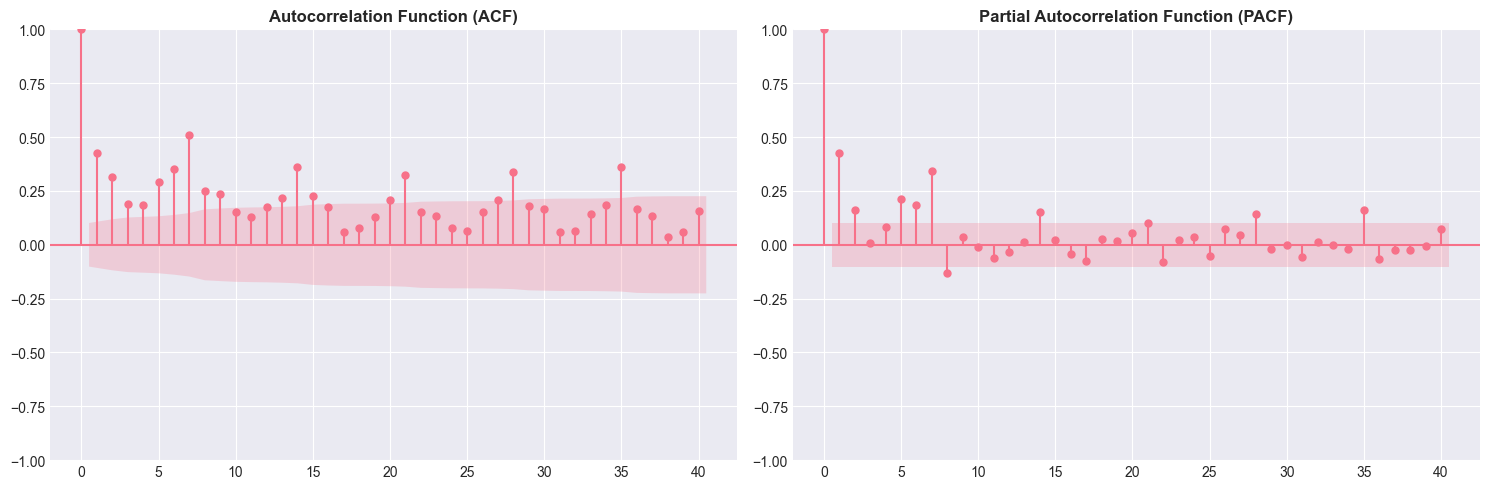

In [ ]:
# ===== AUTOCORRELATION ANALYSIS =====
# Plot ACF dan PACF untuk membantu identifikasi parameter ARIMA

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF (Autocorrelation Function): melihat dependensi dengan nilai sebelumnya
plot_acf(ts_data['TotalRevenue'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')

# PACF (Partial Autocorrelation Function): melihat dependensi langsung
plot_pacf(ts_data['TotalRevenue'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Total Data Points: 374
Training Set: 299 days (2018-12-01 00:00:00 to 2019-09-25 00:00:00)
Test Set: 75 days (2019-09-26 00:00:00 to 2019-12-09 00:00:00)


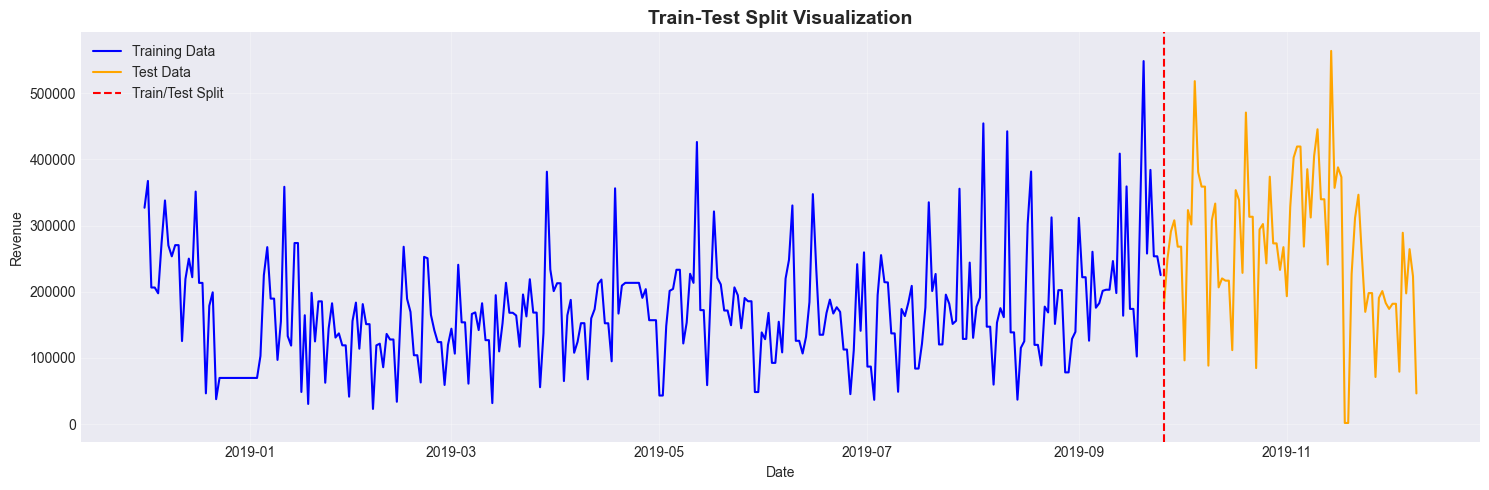

In [ ]:
# ===== TRAIN-TEST SPLIT =====
# Membagi data menjadi training (80%) dan testing (20%) untuk evaluasi model

# Split data: 80% untuk training, 20% untuk testing
train_size = int(len(ts_data) * 0.8)
train_data = ts_data['TotalRevenue'][:train_size]
test_data = ts_data['TotalRevenue'][train_size:]

print(f"Total Data Points: {len(ts_data)}")
print(f"Training Set: {len(train_data)} days ({train_data.index[0]} to {train_data.index[-1]})")
print(f"Test Set: {len(test_data)} days ({test_data.index[0]} to {test_data.index[-1]})")

# Visualisasi train-test split
plt.figure(figsize=(15, 5))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Test Data', color='orange')
plt.axvline(x=test_data.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.title('Train-Test Split Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ===== MODEL 1: MOVING AVERAGE =====
# Model sederhana yang menggunakan rata-rata N hari sebelumnya untuk forecast

window_size = 7  # Menggunakan rata-rata 7 hari terakhir

# Hitung moving average untuk data training
ma_train = train_data.rolling(window=window_size).mean()

# Forecast untuk test set dengan menggeser window secara dinamis
ma_forecast = []
for i in range(len(test_data)):
    if i == 0:
        # Untuk forecast pertama, gunakan akhir dari training data
        window_values = train_data.iloc[-window_size:].values
    else:
        # Untuk forecast berikutnya, kombinasikan training data dan forecast sebelumnya
        window_values = list(train_data.iloc[-(window_size-i):].values) + ma_forecast[:i]
        window_values = window_values[-window_size:]
    
    # Hitung rata-rata untuk forecast
    ma_forecast.append(np.mean(window_values))

# Convert ke Series dengan index yang sesuai
ma_forecast = pd.Series(ma_forecast, index=test_data.index)

print(f"Moving Average Model (Window={window_size} days)")
print("="*50)
print(f"Forecast generated for {len(ma_forecast)} days")
print(f"\nFirst 5 predictions:")
print(ma_forecast.head())

Moving Average Model (Window=7 days)
Forecast generated for 75 days

First 5 predictions:
Date
2019-09-26    321330.954286
2019-09-27    320486.626327
2019-09-28    287927.688659
2019-09-29    292253.289896
2019-09-30    279147.741310
Freq: D, dtype: float64


In [ ]:
# ===== EVALUATE MOVING AVERAGE MODEL =====
# Hitung error metrics untuk model Moving Average

# MAE: Mean Absolute Error - rata-rata nilai absolut error
mae_ma = mean_absolute_error(test_data, ma_forecast)

# RMSE: Root Mean Squared Error - akar dari rata-rata squared error
rmse_ma = np.sqrt(mean_squared_error(test_data, ma_forecast))

print("Moving Average Model - Performance Metrics")
print("="*50)
print(f"MAE (Mean Absolute Error): {mae_ma:,.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse_ma:,.2f}")
print("="*50)

Moving Average Model - Performance Metrics
MAE (Mean Absolute Error): 88,998.13
RMSE (Root Mean Squared Error): 113,948.68


In [ ]:
# ===== MODEL 2: EXPONENTIAL SMOOTHING =====
# Model yang memberikan bobot lebih tinggi untuk data terbaru
# Holt-Winters dengan trend dan seasonal component

print("Training Exponential Smoothing Model...")
print("="*50)

try:
    # Coba model dengan trend additif dan seasonal (7-day period)
    es_model = ExponentialSmoothing(
        train_data,
        seasonal_periods=7,  # Period untuk seasonal component (mingguan)
        trend='add',         # Trend additif
        seasonal='add',      # Seasonal additif
        initialization_method='estimated'
    )
    es_fit = es_model.fit(optimized=True)
    es_forecast = es_fit.forecast(steps=len(test_data))
    
    print("✓ Exponential Smoothing model trained successfully")
    print(f"  Model: Holt-Winters (Trend + Seasonal)")
    print(f"  Seasonal Period: 7 days")
    
except:
    # Fallback: gunakan Simple Exponential Smoothing jika model kompleks gagal
    print("⚠ Seasonal model failed, using Simple Exponential Smoothing")
    es_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
    es_fit = es_model.fit(optimized=True)
    es_forecast = es_fit.forecast(steps=len(test_data))

print("="*50)
print(f"\nForecast generated for {len(es_forecast)} days")
print(f"\nFirst 5 predictions:")
print(es_forecast.head())

Training Exponential Smoothing Model...
✓ Exponential Smoothing model trained successfully
  Model: Holt-Winters (Trend + Seasonal)
  Seasonal Period: 7 days

Forecast generated for 75 days

First 5 predictions:
2019-09-26    279618.210627
2019-09-27    334657.196464
2019-09-28    299123.687223
2019-09-29    373586.876544
2019-09-30    258688.471176
Freq: D, dtype: float64


In [ ]:
# ===== EVALUATE EXPONENTIAL SMOOTHING MODEL =====
# Hitung error metrics untuk model Exponential Smoothing

mae_es = mean_absolute_error(test_data, es_forecast)
rmse_es = np.sqrt(mean_squared_error(test_data, es_forecast))

print("Exponential Smoothing Model - Performance Metrics")
print("="*50)
print(f"MAE (Mean Absolute Error): {mae_es:,.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse_es:,.2f}")
print("="*50)

Exponential Smoothing Model - Performance Metrics
MAE (Mean Absolute Error): 80,943.35
RMSE (Root Mean Squared Error): 105,677.12


## 9. Model 3: ARIMA (Autoregressive Integrated Moving Average)

In [ ]:
# ===== FIND BEST ARIMA PARAMETERS =====
# Mencoba berbagai kombinasi parameter ARIMA dan memilih yang terbaik berdasarkan AIC

print("Training ARIMA Models with different parameters...")
print("="*50)

# Konfigurasi ARIMA yang akan diuji: (p, d, q)
arima_configs = [
    (1, 1, 1), (2, 1, 2), (1, 1, 2), (2, 1, 1),
    (3, 1, 2), (1, 0, 1), (2, 0, 2)
]

best_aic = np.inf  # Inisialisasi dengan nilai sangat besar
best_model = None
best_order = None
results_list = []

# Fit setiap ARIMA configuration
for order in arima_configs:
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        aic = model_fit.aic  # AIC: Akaike Information Criterion (lebih kecil = lebih baik)
        
        results_list.append({
            'Order': order,
            'AIC': aic,
            'Status': 'Success'
        })
        
        # Pilih model dengan AIC terendah
        if aic < best_aic:
            best_aic = aic
            best_model = model_fit
            best_order = order
            
    except Exception as e:
        results_list.append({
            'Order': order,
            'AIC': None,
            'Status': f'Failed: {str(e)[:30]}'
        })

# Tampilkan hasil perbandingan
results_df = pd.DataFrame(results_list)
print("\nARIMA Model Selection Results:")
print(results_df.to_string(index=False))
print("\n" + "="*50)
print(f"✓ Best ARIMA Model: ARIMA{best_order}")
print(f"  AIC: {best_aic:.2f}")
print("="*50)

Training ARIMA Models with different parameters...

ARIMA Model Selection Results:
    Order         AIC  Status
(1, 1, 1) 7569.020305 Success
(2, 1, 2) 7568.754571 Success
(1, 1, 2) 7565.831869 Success
(2, 1, 1) 7569.399100 Success
(3, 1, 2) 7552.605879 Success
(1, 0, 1) 7593.889540 Success
(2, 0, 2) 7592.607424 Success

✓ Best ARIMA Model: ARIMA(3, 1, 2)
  AIC: 7552.61


In [ ]:
# ===== GENERATE ARIMA FORECAST =====
# Generate forecast untuk test set menggunakan best ARIMA model

# Forecast untuk test set
arima_forecast = best_model.forecast(steps=len(test_data))
arima_forecast.index = test_data.index  # Set index yang sesuai dengan test data

print(f"ARIMA{best_order} Forecast Summary")
print("="*50)
print(f"Forecast generated for {len(arima_forecast)} days")
print(f"\nFirst 5 predictions:")
print(arima_forecast.head())
print(f"\nModel Summary:")
print(best_model.summary())  # Tampilkan detail model fitting

ARIMA(3, 1, 2) Forecast Summary
Forecast generated for 75 days

First 5 predictions:
Date
2019-09-26    315450.134916
2019-09-27    344947.625933
2019-09-28    352431.234792
2019-09-29    323637.955055
2019-09-30    294874.183103
Freq: D, Name: predicted_mean, dtype: float64

Model Summary:
                               SARIMAX Results                                
Dep. Variable:           TotalRevenue   No. Observations:                  299
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3770.303
Date:                Fri, 12 Dec 2025   AIC                           7552.606
Time:                        13:44:55   BIC                           7574.788
Sample:                    12-01-2018   HQIC                          7561.485
                         - 09-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

In [ ]:
# ===== EVALUATE ARIMA MODEL =====
# Hitung error metrics untuk model ARIMA

mae_arima = mean_absolute_error(test_data, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test_data, arima_forecast))

print(f"ARIMA{best_order} Model - Performance Metrics")
print("="*50)
print(f"MAE (Mean Absolute Error): {mae_arima:,.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse_arima:,.2f}")
print("="*50)

ARIMA(3, 1, 2) Model - Performance Metrics
MAE (Mean Absolute Error): 91,626.19
RMSE (Root Mean Squared Error): 117,138.30


## 10. Model Comparison and Visualization

In [ ]:
# ===== COMPARE ALL MODELS =====
# Membandingkan performa ketiga model dengan metrics MAE dan RMSE

# Buat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    'Model': ['Moving Average', 'Exponential Smoothing', f'ARIMA{best_order}'],
    'MAE': [mae_ma, mae_es, mae_arima],
    'RMSE': [rmse_ma, rmse_es, rmse_arima]
})

# Hitung peningkatan performa dibanding Moving Average (baseline)
comparison_df['MAE_Improvement_%'] = ((mae_ma - comparison_df['MAE']) / mae_ma * 100).round(2)
comparison_df['RMSE_Improvement_%'] = ((rmse_ma - comparison_df['RMSE']) / rmse_ma * 100).round(2)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Identifikasi model terbaik berdasarkan MAE terendah
best_model_name = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   (Lowest MAE: {comparison_df['MAE'].min():,.2f})")
print("="*70)


MODEL PERFORMANCE COMPARISON
                Model          MAE          RMSE  MAE_Improvement_%  RMSE_Improvement_%
       Moving Average 88998.130337 113948.680212               0.00                0.00
Exponential Smoothing 80943.350267 105677.122617               9.05                7.26
       ARIMA(3, 1, 2) 91626.189469 117138.299952              -2.95               -2.80

🏆 BEST MODEL: Exponential Smoothing
   (Lowest MAE: 80,943.35)


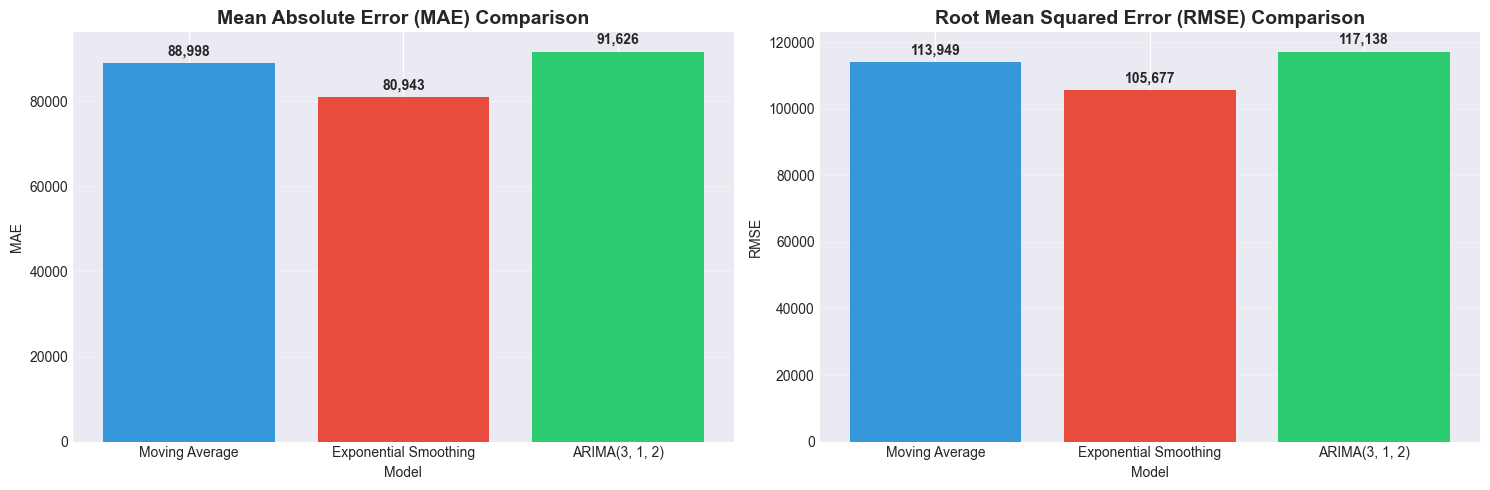

In [ ]:
# ===== VISUALISASI PERBANDINGAN ERROR METRICS =====
# Bar chart untuk MAE dan RMSE dari ketiga model

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: MAE Comparison
axes[0].bar(comparison_df['Model'], comparison_df['MAE'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Mean Absolute Error (MAE) Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Model')
axes[0].grid(True, alpha=0.3, axis='y')
# Tampilkan nilai di atas bar
for i, v in enumerate(comparison_df['MAE']):
    axes[0].text(i, v + max(comparison_df['MAE'])*0.02, f'{v:,.0f}', ha='center', fontweight='bold')

# Plot 2: RMSE Comparison
axes[1].bar(comparison_df['Model'], comparison_df['RMSE'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Root Mean Squared Error (RMSE) Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Model')
axes[1].grid(True, alpha=0.3, axis='y')
# Tampilkan nilai di atas bar
for i, v in enumerate(comparison_df['RMSE']):
    axes[1].text(i, v + max(comparison_df['RMSE'])*0.02, f'{v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

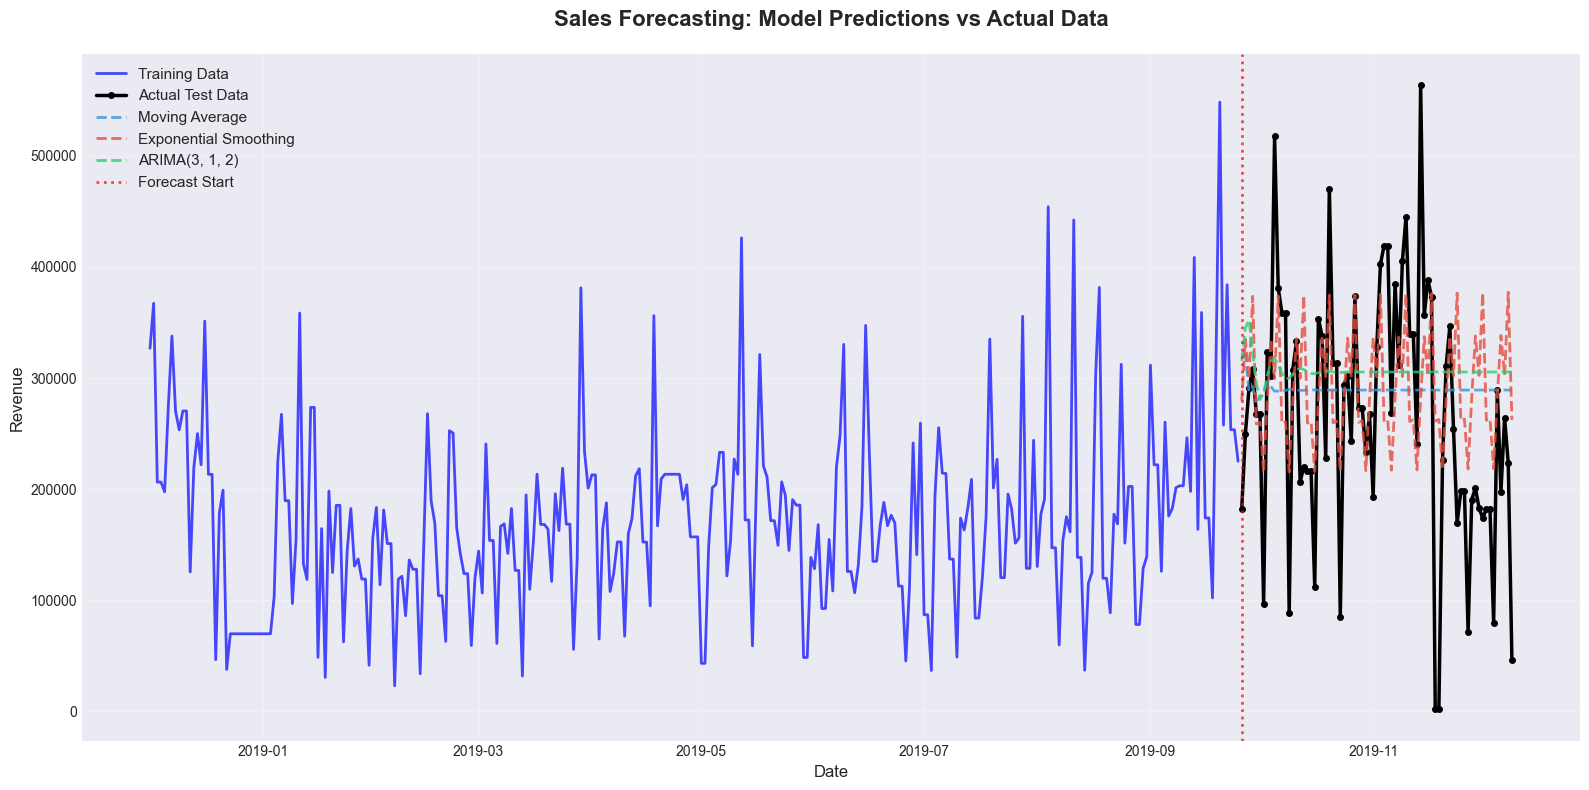

In [ ]:
# ===== VISUALISASI FORECAST KESELURUHAN =====
# Plot training data, test data actual, dan predictions dari ketiga model

plt.figure(figsize=(16, 8))

# Plot training data
plt.plot(train_data.index, train_data, label='Training Data', color='blue', linewidth=2, alpha=0.7)

# Plot actual test data
plt.plot(test_data.index, test_data, label='Actual Test Data', color='black', linewidth=2.5, linestyle='-', marker='o', markersize=4)

# Plot predictions dari ketiga model
plt.plot(ma_forecast.index, ma_forecast, label='Moving Average', color='#3498db', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(es_forecast.index, es_forecast, label='Exponential Smoothing', color='#e74c3c', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(arima_forecast.index, arima_forecast, label=f'ARIMA{best_order}', color='#2ecc71', linewidth=2, linestyle='--', alpha=0.8)

# Tandai batas train/test
plt.axvline(x=test_data.index[0], color='red', linestyle=':', linewidth=2, label='Forecast Start', alpha=0.7)

plt.title('Sales Forecasting: Model Predictions vs Actual Data', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

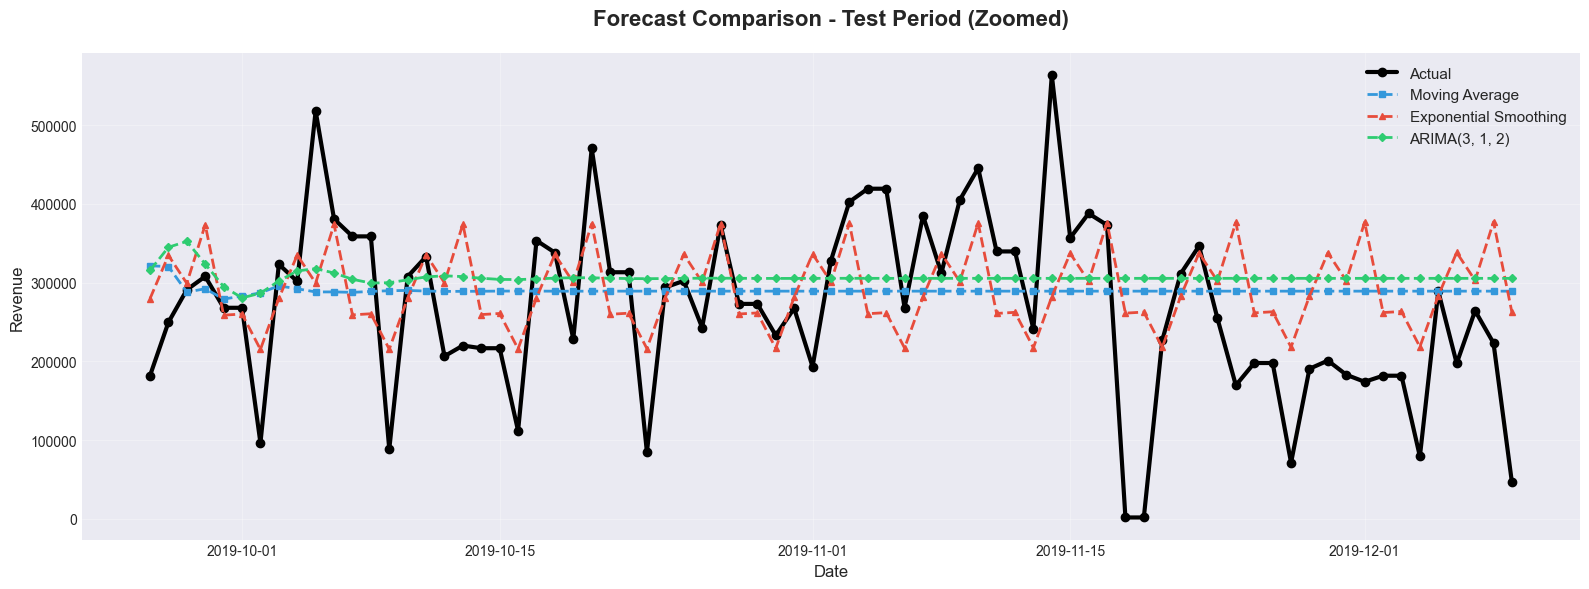

In [ ]:
# ===== VISUALISASI FORECAST TEST PERIOD (ZOOM) =====
# Fokus pada periode test untuk melihat detail perbandingan predictions

plt.figure(figsize=(16, 6))

# Plot actual test data
plt.plot(test_data.index, test_data, label='Actual', color='black', linewidth=3, marker='o', markersize=6)

# Plot predictions dari ketiga model dengan marker berbeda
plt.plot(ma_forecast.index, ma_forecast, label='Moving Average', color='#3498db', linewidth=2, linestyle='--', marker='s', markersize=4)
plt.plot(es_forecast.index, es_forecast, label='Exponential Smoothing', color='#e74c3c', linewidth=2, linestyle='--', marker='^', markersize=4)
plt.plot(arima_forecast.index, arima_forecast, label=f'ARIMA{best_order}', color='#2ecc71', linewidth=2, linestyle='--', marker='D', markersize=4)

plt.title('Forecast Comparison - Test Period (Zoomed)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ===== GENERATE 30-DAY FUTURE FORECAST =====
# Menggunakan best model (ARIMA) untuk forecast revenue 30 hari ke depan

print("Generating 30-Day Future Forecast...")
print("="*50)

# Gunakan seluruh dataset untuk retrain model
full_data = ts_data['TotalRevenue']

# Retrain ARIMA model dengan parameter terbaik menggunakan semua data
final_arima_model = ARIMA(full_data, order=best_order)
final_arima_fit = final_arima_model.fit()

# Generate forecast untuk 30 hari ke depan
forecast_days = 30
future_forecast_arima = final_arima_fit.forecast(steps=forecast_days)

# Buat date range untuk forecast period
last_date = full_data.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='D')
future_forecast_arima.index = future_dates

print(f"✓ ARIMA{best_order} model retrained on full dataset")
print(f"✓ Forecast generated for next {forecast_days} days")
print(f"  From: {future_dates[0].date()}")
print(f"  To: {future_dates[-1].date()}")
print("="*50)

# Buat summary DataFrame
forecast_summary = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Revenue': future_forecast_arima.values
})

print("\nFuture Revenue Forecast (Next 30 Days):")
print(forecast_summary.to_string(index=False))
print("\n" + "="*50)
print(f"Total Forecasted Revenue (30 days): {future_forecast_arima.sum():,.2f}")
print(f"Average Daily Revenue (forecast): {future_forecast_arima.mean():,.2f}")
print("="*50)

Generating 30-Day Future Forecast...
✓ ARIMA(3, 1, 2) model retrained on full dataset
✓ Forecast generated for next 30 days
  From: 2019-12-10
  To: 2020-01-08

Future Revenue Forecast (Next 30 Days):
      Date  Forecasted Revenue
2019-12-10       142012.132501
2019-12-11       164498.365394
2019-12-12       209541.922316
2019-12-13       206769.163625
2019-12-14       191393.356354
2019-12-15       170499.287554
2019-12-16       161374.222540
2019-12-17       163623.654443
2019-12-18       172164.345539
2019-12-19       179352.382198
2019-12-20       181589.935774
2019-12-21       179398.403014
2019-12-22       175766.189264
2019-12-23       173362.951872
2019-12-24       173135.779567
2019-12-25       174389.713387
2019-12-26       175827.137919
2019-12-27       176534.632763
2019-12-28       176374.481406
2019-12-29       175770.169154
2019-12-30       175245.015928
2019-12-31       175077.073396
2020-01-01       175229.198988
2020-01-02       175490.552773
2020-01-03       175666.

In [ ]:
# ===== DEMAND PERIOD ANALYSIS =====
# Klasifikasi hari-hari dengan high/low demand berdasarkan statistik

# Hitung statistik dari revenue historical
daily_stats = ts_data['TotalRevenue'].describe()

# Define threshold: high demand > mean + 1 std, low demand < mean - 1 std
high_threshold = daily_stats['mean'] + daily_stats['std']
low_threshold = daily_stats['mean'] - daily_stats['std']

# Filter hari dengan high dan low demand
high_demand_days = ts_data[ts_data['TotalRevenue'] > high_threshold]
low_demand_days = ts_data[ts_data['TotalRevenue'] < low_threshold]

print("\nDemand Period Analysis")
print("="*70)
print(f"Average Daily Revenue: ${daily_stats['mean']:,.2f}")
print(f"Standard Deviation: ${daily_stats['std']:,.2f}")
print(f"\nHigh Demand Threshold: > ${high_threshold:,.2f}")
print(f"High Demand Days: {len(high_demand_days)} days ({len(high_demand_days)/len(ts_data)*100:.1f}%)")
print(f"\nLow Demand Threshold: < ${low_threshold:,.2f}")
print(f"Low Demand Days: {len(low_demand_days)} days ({len(low_demand_days)/len(ts_data)*100:.1f}%)")

if len(high_demand_days) > 0:
    print(f"\nSample High Demand Days:")
    print(high_demand_days.head())
    
if len(low_demand_days) > 0:
    print(f"\nSample Low Demand Days:")
    print(low_demand_days.head())

print("="*70)


Demand Period Analysis
Average Daily Revenue: $191,772.13
Standard Deviation: $96,979.05

High Demand Threshold: > $288,751.18
High Demand Days: 59 days (15.8%)

Low Demand Threshold: < $94,793.08
Low Demand Days: 54 days (14.4%)

Sample High Demand Days:
            NumTransactions  TotalQuantity  TotalRevenue
Date                                                    
2018-12-01             3061          26889     326820.08
2018-12-02             2057          31297     367316.62
2018-12-07             2904          25307     337840.78
2018-12-16             1746          29926     351260.49
2019-01-11             1392          28435     358480.09

Sample Low Demand Days:
            NumTransactions  TotalQuantity  TotalRevenue
Date                                                    
2018-12-19              516           3794      46421.37
2018-12-22              284           3209      37637.26
2018-12-23              937           5725      69708.61
2018-12-24              937       

In [ ]:
# ===== PRODUCT CLASSIFICATION - ABC ANALYSIS =====
# Mengklasifikasi produk berdasarkan kontribusi terhadap revenue

# Agregasi data per produk
product_sales = df.groupby(['ProductNo', 'ProductName']).agg({
    'TransactionNo': 'count',  # Jumlah transaksi
    'Quantity': 'sum',          # Total quantity terjual
    'Revenue': 'sum'            # Total revenue
}).reset_index()

# Rename kolom
product_sales.columns = ['ProductNo', 'ProductName', 'NumTransactions', 
                        'TotalQuantity', 'TotalRevenue']

# Sort berdasarkan revenue (tertinggi ke terendah)
product_sales = product_sales.sort_values('TotalRevenue', ascending=False).reset_index(drop=True)

# Hitung persentase revenue dan cumulative percentage
product_sales['RevenuePct'] = (product_sales['TotalRevenue'] / 
                               product_sales['TotalRevenue'].sum() * 100)
product_sales['CumulativePct'] = product_sales['RevenuePct'].cumsum()

# Fungsi untuk klasifikasi ABC
def classify_abc(cum_pct):
    """
    Klasifikasi produk berdasarkan cumulative revenue:
    A: Top 80% revenue (best sellers)
    B: 80-95% revenue (moderate sellers)
    C: 95-100% revenue (slow movers)
    """
    if cum_pct <= 80:
        return 'A - Best Sellers (Top 80% Revenue)'
    elif cum_pct <= 95:
        return 'B - Moderate Sellers'
    else:
        return 'C - Slow Movers'

# Aplikasikan klasifikasi
product_sales['Category'] = product_sales['CumulativePct'].apply(classify_abc)

# Analisis penjualan berdasarkan hari dalam seminggu
df['DayOfWeek'] = df['Date'].dt.day_name()
dow_sales = df.groupby('DayOfWeek')['Revenue'].sum().sort_values(ascending=False)

# Reorder berdasarkan hari dalam seminggu
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_revenue = [dow_sales.get(day, 0) for day in dow_order]

# Warna untuk setiap hari
colors_dow = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

print("✓ Dashboard variables created successfully")
print(f"  Products: {len(product_sales)}")
print(f"  Top product: {product_sales.iloc[0]['ProductName']}")
print(f"  Best day: {dow_sales.index[0]}")

✓ Dashboard variables created successfully
  Products: 3752
  Top product: Popcorn Holder
  Best day: Sunday


In [ ]:
# ===== INTERACTIVE DASHBOARD - PART 1 =====
# Membuat dashboard interaktif dengan 4 visualisasi utama menggunakan Plotly

# Import Plotly untuk visualisasi interaktif
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Buat subplot dengan 2x2 layout
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Historical & Forecast Revenue', 'Top 10 Products by Revenue',
                    'Model Performance Comparison', 'Revenue by Day of Week'),
    specs=[[{"type": "scatter"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# Subplot 1: Historical and forecast revenue
fig.add_trace(
    go.Scatter(x=train_data.index, y=train_data, name='Training Data',
               line=dict(color='blue', width=2), mode='lines'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=test_data.index, y=test_data, name='Test Data',
               line=dict(color='black', width=2), mode='lines+markers'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=arima_forecast.index, y=arima_forecast, name=f'ARIMA{best_order} Forecast',
               line=dict(color='green', width=2, dash='dash'), mode='lines'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=future_forecast_arima.index, y=future_forecast_arima, 
               name='30-Day Future Forecast',
               line=dict(color='red', width=3, dash='dot'), mode='lines+markers'),
    row=1, col=1
)

# Subplot 2: Top 10 products by revenue
top10_products = product_sales.head(10)
fig.add_trace(
    go.Bar(x=top10_products['TotalRevenue'], y=top10_products['ProductName'],
           orientation='h', name='Revenue', marker=dict(color='lightgreen'),
           text=top10_products['TotalRevenue'].round(0),
           textposition='outside'),
    row=1, col=2
)

# Subplot 3: Model performance comparison (MAE)
fig.add_trace(
    go.Bar(x=comparison_df['Model'], y=comparison_df['MAE'], 
           name='MAE', marker=dict(color=['#3498db', '#e74c3c', '#2ecc71']),
           text=comparison_df['MAE'].round(0),
           textposition='outside'),
    row=2, col=1
)

# Subplot 4: Revenue by day of week
fig.add_trace(
    go.Bar(x=dow_order, y=dow_revenue,
           name='Revenue by Day', marker=dict(color=colors_dow),
           text=[f'{v:,.0f}' for v in dow_revenue],
           textposition='outside'),
    row=2, col=2
)

# Update layout dan axes
fig.update_layout(
    title_text="<b>Sales Forecasting Dashboard</b>",
    title_font_size=20,
    showlegend=True,
    height=800,
    hovermode='x unified'
)

fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Revenue", row=1, col=1)
fig.update_xaxes(title_text="Revenue", row=1, col=2)
fig.update_yaxes(title_text="Product", row=1, col=2)
fig.update_xaxes(title_text="Model", row=2, col=1)
fig.update_yaxes(title_text="MAE", row=2, col=1)
fig.update_xaxes(title_text="Day", row=2, col=2)
fig.update_yaxes(title_text="Revenue", row=2, col=2)

fig

In [ ]:
# ===== INTERACTIVE DASHBOARD - ABC ANALYSIS =====
# Scatter plot interaktif untuk ABC analysis (quantity vs revenue)

fig2 = go.Figure()

# Tambahkan trace untuk setiap kategori ABC dengan warna berbeda
for category in ['A - Best Sellers (Top 80% Revenue)', 'B - Moderate Sellers', 'C - Slow Movers']:
    cat_data = product_sales[product_sales['Category'] == category]
    fig2.add_trace(go.Scatter(
        x=cat_data['TotalQuantity'],
        y=cat_data['TotalRevenue'],
        mode='markers',
        name=category,
        text=cat_data['ProductName'],  # Tampilkan nama produk saat hover
        marker=dict(size=10),
        hovertemplate='<b>%{text}</b><br>Quantity: %{x}<br>Revenue: $%{y:,.0f}<extra></extra>'
    ))

# Update layout
fig2.update_layout(
    title='<b>Product Performance Matrix (ABC Analysis)</b>',
    xaxis_title='Total Quantity Sold',
    yaxis_title='Total Revenue',
    hovermode='closest',
    height=600,
    showlegend=True
)

fig2.show()

In [ ]:
# ===== INTERACTIVE DASHBOARD - FORECAST WITH CONFIDENCE INTERVAL =====
# Visualisasi forecast 30 hari dengan confidence band (95%)

# Hitung confidence interval (±1.96 × standard error)
std_error = ts_data['TotalRevenue'].std() * 0.1
upper_bound = future_forecast_arima + 1.96 * std_error
lower_bound = future_forecast_arima - 1.96 * std_error

fig3 = go.Figure()

# Plot 1: Historical revenue
fig3.add_trace(go.Scatter(
    x=full_data.index,
    y=full_data,
    name='Historical Revenue',
    line=dict(color='#3498db', width=2),
    hovertemplate='Date: %{x}<br>Revenue: $%{y:,.0f}<extra></extra>'
))

# Plot 2: 30-day forecast
fig3.add_trace(go.Scatter(
    x=future_forecast_arima.index,
    y=future_forecast_arima,
    name='30-Day Forecast',
    line=dict(color='#e74c3c', width=3, dash='dash'),
    hovertemplate='Date: %{x}<br>Forecast: $%{y:,.0f}<extra></extra>'
))

# Plot 3: Upper confidence bound (fill none dulu)
fig3.add_trace(go.Scatter(
    x=future_forecast_arima.index,
    y=upper_bound,
    fill=None,
    mode='lines',
    line=dict(color='rgba(231, 76, 60, 0.2)'),
    showlegend=False,
    hoverinfo='skip'
))

# Plot 4: Lower confidence bound dengan fill to upper
fig3.add_trace(go.Scatter(
    x=future_forecast_arima.index,
    y=lower_bound,
    fill='tonexty',  # Fill antara lower dan upper
    mode='lines',
    line=dict(color='rgba(231, 76, 60, 0.2)'),
    name='95% Confidence',
    hoverinfo='skip'
))

# Tambahkan horizontal lines untuk high/low demand thresholds
fig3.add_hline(y=high_threshold, line_dash="dot", line_color="green", 
               annotation_text="High Demand Threshold")
fig3.add_hline(y=low_threshold, line_dash="dot", line_color="red",
               annotation_text="Low Demand Threshold")

# Update layout
fig3.update_layout(
    title='<b>Revenue Forecast with Confidence Interval</b>',
    xaxis_title='Date',
    yaxis_title='Revenue ($)',
    hovermode='x unified',
    height=600
)

fig3.show()

In [ ]:
# ===== EXPORT RESULTS TO CSV =====
# Menyimpan hasil analisis ke dalam file CSV untuk referensi dan reporting

# Export 1: 30-day forecast
forecast_summary.to_csv('sales_forecast_30days.csv', index=False)

# Export 2: Product classification ABC
product_classification = product_sales[['ProductNo', 'ProductName', 'TotalRevenue', 
                                       'TotalQuantity', 'Category', 'RevenuePct']].copy()
product_classification.to_csv('product_classification_abc.csv', index=False)

# Export 3: Seasonal analysis (revenue by day of week)
seasonal_summary = pd.DataFrame({
    'DayOfWeek': dow_order,
    'TotalRevenue': dow_revenue
})
seasonal_summary.to_csv('seasonal_analysis.csv', index=False)

print("\n" + "="*80)
print("📁 EXPORTED FILES:")
print("="*80)
print("✓ sales_forecast_30days.csv - Revenue forecast for next 30 days")
print("✓ product_classification_abc.csv - Product performance classification")
print("✓ seasonal_analysis.csv - Seasonal sales patterns")
print("="*80)

print("\n✅ Sales Forecasting Analysis Complete!")
print("\nAll forecasts, analyses, and interactive dashboards are ready.")
print("Use the exported CSV files for revenue planning and strategic decision-making.")


📁 EXPORTED FILES:
✓ sales_forecast_30days.csv - Revenue forecast for next 30 days
✓ product_classification_abc.csv - Product performance classification
✓ seasonal_analysis.csv - Seasonal sales patterns

✅ Sales Forecasting Analysis Complete!

All forecasts, analyses, and interactive dashboards are ready.
Use the exported CSV files for revenue planning and strategic decision-making.


In [ ]:
# ===== SAVE TRAINED MODELS =====
# Menyimpan model yang sudah dilatih untuk digunakan kembali di masa depan

import pickle
import joblib
import os

# Buat folder 'models' jika belum ada
os.makedirs('models', exist_ok=True)

print("\n" + "="*80)
print("💾 SAVING TRAINED MODELS...")
print("="*80)

# Simpan ARIMA model
joblib.dump(final_arima_fit, 'models/arima_model.pkl')
print("✓ ARIMA model saved to: models/arima_model.pkl")

# Simpan Exponential Smoothing model
joblib.dump(es_fit, 'models/es_model.pkl')
print("✓ Exponential Smoothing model saved to: models/es_model.pkl")

# Simpan Moving Average statistics
with open('models/ma_stats.pkl', 'wb') as f:
    pickle.dump({
        'ma_value': ma_train.mean(),
        'train_data_mean': train_data.mean(),
        'train_data_std': train_data.std()
    }, f)
print("✓ Moving Average statistics saved to: models/ma_stats.pkl")

# Simpan metadata model untuk referensi
model_metadata = {
    'best_order': best_order,
    'best_aic': float(best_aic),
    'train_size': len(train_data),
    'test_size': len(test_data),
    'mae_ma': float(mae_ma),
    'mae_es': float(mae_es),
    'mae_arima': float(mae_arima),
    'rmse_ma': float(rmse_ma),
    'rmse_es': float(rmse_es),
    'rmse_arima': float(rmse_arima),
    'best_model_name': best_model_name,
    'forecast_date': str(pd.Timestamp.now()),
    'full_data_length': len(full_data)
}

with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)
print("✓ Model metadata saved to: models/model_metadata.pkl")

print("="*80)
print("✅ All models saved successfully!")
print("="*80)


💾 SAVING TRAINED MODELS...
✓ ARIMA model saved to: models/arima_model.pkl
✓ Exponential Smoothing model saved to: models/es_model.pkl
✓ Moving Average statistics saved to: models/ma_stats.pkl
✓ Model metadata saved to: models/model_metadata.pkl
✅ All models saved successfully!
